## Machine learning classification of single-cell data - Random Forest

In [1]:
import pandas as pd
import scanpy as sc
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import random

In [2]:
annotations = sc.read_h5ad('../complete_class/integrated.h5ad') #dont worry about this, get UMAP coords and labels
adata = sc.read_h5ad('../complete_class/combined.h5ad') #raw data
adata.obsm['X_umap'] = annotations.obsm['X_umap'] #add umap coords
adata.obs['cell_type'] = annotations.obs['cell type'] #add cell labels

adata

AnnData object with n_obs × n_vars = 98979 × 29037
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'cell_type'
    var: 'n_cells'
    obsm: 'X_umap'

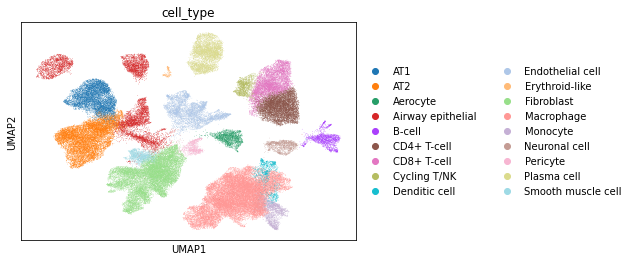

In [3]:
sc.pl.umap(adata, color='cell_type')

In [4]:
sc.pp.filter_genes(adata, min_cells=100)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [5]:
def label(x):
    if x == 'Endothelial cell':
        return 1
    else:
        return 0

In [6]:
y = adata.obs.cell_type.map(label)

In [7]:
sel = RandomForestClassifier(n_jobs = 10, n_estimators=100)
sel.fit(adata.X, y)

RandomForestClassifier(n_jobs=10)

In [8]:
pd.DataFrame(sel.feature_importances_,
                  index = adata.var_names).sort_values(0, ascending = False)

,0
ADGRL2,0.024497
SLCO2A1,0.022095
SHANK3,0.017932
VWF,0.017882
FLT1,0.015993
...,...
ZNF214,0.000000
NLRP14,0.000000
SYT9,0.000000
OLFML1,0.000000


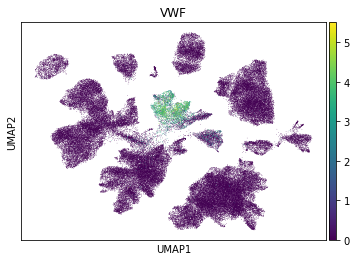

In [9]:
sc.pl.umap(annotations, color = 'VWF')

In [10]:
a = sel.predict(adata.X)

In [11]:
adata.obs['predictions'] = a

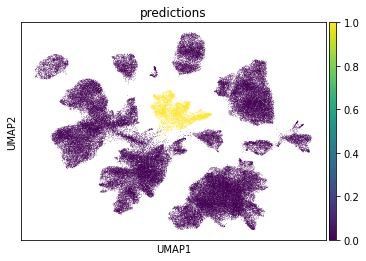

In [12]:
sc.pl.umap(adata, color = 'predictions')

## Classify cells

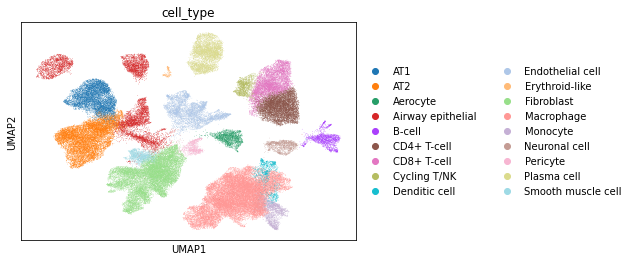

In [13]:
sc.pl.umap(adata, color='cell_type')

In [14]:
#sc.pp.filter_genes(var_names, min_cells=100)
#sc.pp.normalize_total(adata, target_sum=1e4)
#sc.pp.log1p(adata)

In [15]:
num = len(adata[adata.obs.cell_type.isin(['Endothelial cell', 'Aerocyte'])])
num

6714

In [16]:
barcodes = random.choices(adata[~adata.obs.cell_type.isin(['Endothelial cell', 'Aerocyte'])].obs.index, k = num)

In [17]:
len(barcodes)

6714

In [18]:
barcodes = barcodes + adata[adata.obs.cell_type.isin(['Endothelial cell', 'Aerocyte'])].obs.index.tolist()

In [19]:
len(barcodes)

13428

In [34]:
train = adata[barcodes]
train

View of AnnData object with n_obs × n_vars = 13428 × 20631
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'cell_type', 'predictions'
    var: 'n_cells'
    uns: 'cell_type_colors', 'log1p'
    obsm: 'X_umap'

In [35]:
test = sc.read_h5ad('TS_Lung.h5ad')
test

AnnData object with n_obs × n_vars = 35682 × 58870
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '_scvi', '_training_mode', 'cell_ontology_class_colors', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'method_colors', 'neighbors', 'organ_tissue_colors', 'sex_colors', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'decontXcounts', 'raw_counts'
    obsp: 'connectivities', 'distances'

In [36]:
var_names = sc.concat((train, test))
var_names

/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/merge.py:942: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(
/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 49110 × 19930
    obs: 'n_genes'
    obsm: 'X_umap'

In [37]:
#sc.pp.highly_variable_genes(var_names, subset=True, n_top_genes = 2000)
#higher accuracy without this step in this particular example

In [38]:
var_names = var_names.var_names

In [39]:
test = test[:, var_names]
train = train[:, var_names]

In [40]:
def label_train(x):
    if x == 'Endothelial cell' or x == 'Aerocyte':
        return 1
    else:
        return 0

In [41]:
y = train.obs.cell_type.map(label_train)

In [42]:
sel = RandomForestClassifier(n_estimators=100)
sel.fit(train.X, y)

RandomForestClassifier()

In [43]:
predictions = sel.predict(test.X)
test.obs['predictions'] = predictions

/tmp/ipykernel_6073/3875682491.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  test.obs['predictions'] = predictions


In [44]:
def label_test(x):
    if x in ['endothelial cell of artery', 
             'capillary endothelial cell', 'capillary aerocyte', 
             'vein endothelial cell', 'lung microvascular endothelial cell']:
        return 1
    else:
        return 0

In [45]:
test.obs['labels'] = test.obs.cell_ontology_class.map(label_test)

In [46]:
metrics.accuracy_score(test.obs['labels'], predictions)

0.9710778543803599

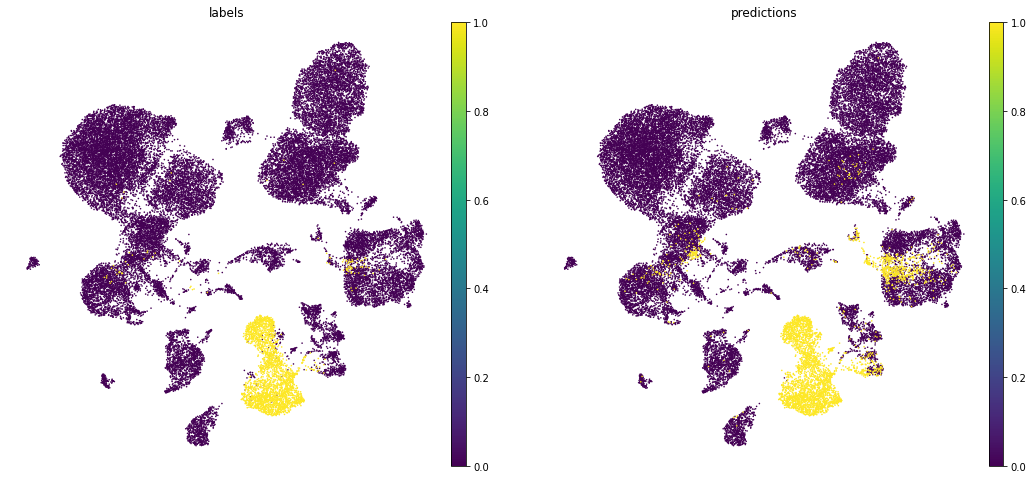

In [51]:
from matplotlib.pyplot import rc_context

with rc_context({'figure.figsize': (8,8)}):
    sc.pl.umap(test, color = ['labels', 'predictions'], frameon = False, s = 10)

## Differentiate between COVID/Non-COVID

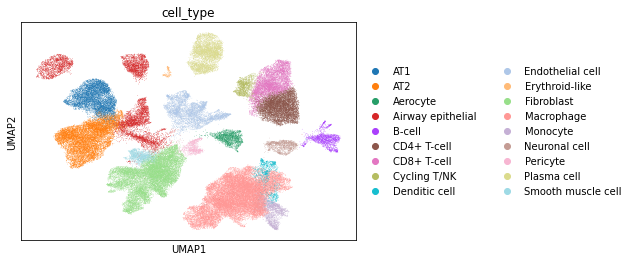

In [51]:
sc.pl.umap(adata, color='cell_type')

In [52]:
at2 = adata[adata.obs.cell_type == "AT2"]
sc.pp.filter_genes(at2, min_cells=100)
sc.pp.highly_variable_genes(at2, subset=True, n_top_genes = 2000)

/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


In [53]:
test_samps = ['L08cov', 'C54ctr']
test = at2[at2.obs.Sample.isin(test_samps)]
train = at2[~at2.obs.Sample.isin(test_samps)]

In [54]:
train

View of AnnData object with n_obs × n_vars = 9730 × 2000
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'cell_type', 'predictions'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_colors', 'log1p', 'hvg'
    obsm: 'X_umap'

In [55]:
test

View of AnnData object with n_obs × n_vars = 1183 × 2000
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'cell_type', 'predictions'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_colors', 'log1p', 'hvg'
    obsm: 'X_umap'

In [57]:
def label_infection(x):
    if 'cov' in x:
        return 1
    else:
        return 0

In [58]:
y = train.obs.Sample.map(label_infection)

In [59]:
sel = RandomForestClassifier(n_jobs = 10, n_estimators=100)
sel.fit(train.X, y)

RandomForestClassifier(n_jobs=10)

In [60]:
predictions = sel.predict(test.X)

In [61]:
lables = test.obs.Sample.map(label_infection)

In [62]:
metrics.accuracy_score(lables, predictions)

0.9881656804733728

In [64]:
df = pd.DataFrame(sel.feature_importances_,
                  index = train.var_names).sort_values(0, ascending = False)

In [65]:
df

,0
AGBL1,3.419645e-02
PDE4D,2.407661e-02
SGMS2,2.038372e-02
MT-CO2,1.946193e-02
ZNF385B,1.726823e-02
...,...
CCBE1,4.135291e-06
PEX11G,3.955128e-06
PPP5D1,3.876950e-06
AL049629.1,7.038674e-07
